# Exploratory Data Analysis

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math

In [4]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
del cwd, path

In [5]:
import KaggleAmazonMain as kam

In [17]:
#Load from pickle unless something has changed
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
#X_train, y_train, names_train, tagged_df = kam.load_training_data(sampleOnly=True) #this creates the pickle

In [8]:
tagged_df.head()

NameError: name 'tagged_df' is not defined

In [9]:
#Barplot of tag counts
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
plt.show()
tagged_df.sum().sort_values(ascending=False)

NameError: name 'tagged_df' is not defined

In [11]:
kam.plot_samples(X_train, names_train, tagged_df, nrow=4, ncol=4)

NameError: name 'names_train' is not defined

# Feature Engineering
What type of features are we working with here?
Feature engineering explores the feature data, and does feature creation.
Each image consists of pixel values in red, geen, and blue color schemes. The patterns in these pixels will  have useful trends for classifying the objects in the images and the image types. Notice how the statistical distributions of the red, green, and blue, pixels differ for different types of tags.

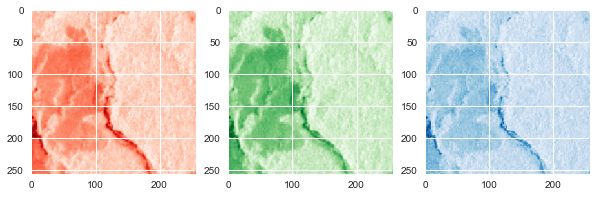

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].imshow(X_train[1,:,:,0], cmap='Reds')
axes[1].imshow(X_train[1,:,:,1], cmap='Greens')
axes[2].imshow(X_train[1,:,:,2], cmap='Blues')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


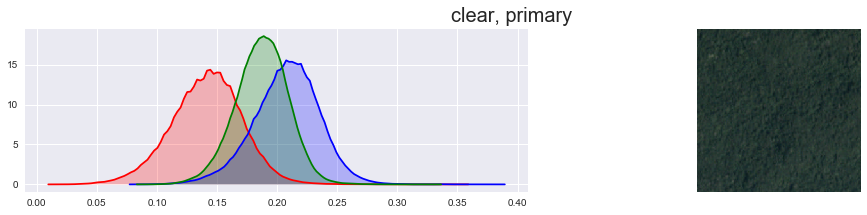

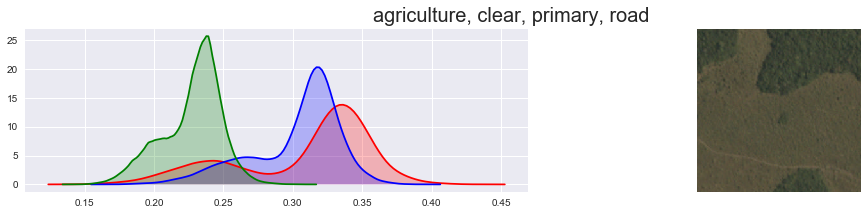

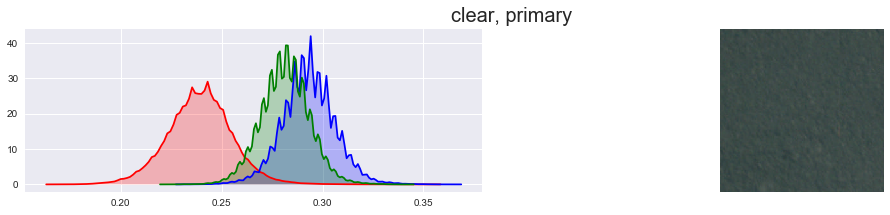

In [11]:
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,3):
    sample = np.random.randint(low=0, high=X_train.shape[0]-1, size = 1)
    ind = names_train[sample[0]]
    tags = kam.get_labels(ind, tagged_df)
    kam.plot_rgb_dist(X_train[sample[0],:,:,:],tags)

Create features from the raw pixel data. These metrics should be metrics that describe patterns in the trends and distributions of the pixels. 
Using binned historgram features to capture bimodality and general shape and location of distributions in red, green, and blue.

I want to try an ML algorithm with feature cdreation, and a NN with raw pixel data to compare results. 

binned mode differences is a feature created to discribe bimodal distributions. A lot of the r g b distributions are bimodal, which could offer interesting insight into the  classificatioin, so I created a feature to capture bimodal patterns in the r g b pixel distributions. The binned mode differences is simply the differnce between the two min bounds of the two largest count bins, or the two modes. If this value is large, then the two larges modes are a large distance from eachother, indicating the distribution is bimodal.

In [12]:
#Binned mode differences

def binned_mode_features_with_diagnostics(img, steps):
    ## red ##
    #split on mean
    m=img[:,:,0].flatten().mean()
    left = img[:,:,0].flatten()[img[:,:,0].flatten()<m]
    right = img[:,:,0].flatten()[img[:,:,0].flatten()>=m]
    #find mode in left and right
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    #calc bimodal metric
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_r=abs(mo1-mo2)
    print("The mean of the red distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,0].flatten(), color='red', bins=steps)
    plt.axvline(img[:,:,0].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## green ##
    m=img[:,:,1].flatten().mean()
    left = img[:,:,1].flatten()[img[:,:,1].flatten()<m]
    right = img[:,:,1].flatten()[img[:,:,1].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_g=abs(mo1-mo2)
    print("The mean of the green distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,1].flatten(), color='green', bins=steps)
    plt.axvline(img[:,:,1].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    ## blue ##
    m=img[:,:,2].flatten().mean()
    left = img[:,:,2].flatten()[img[:,:,2].flatten()<m]
    right = img[:,:,2].flatten()[img[:,:,2].flatten()>=m]
    max_ind_left = np.histogram(left, bins=steps, density=False)[0].argsort()[-1:]
    max_ind_right = np.histogram(right, bins=steps, density=False)[0].argsort()[-1:]
    mo1 = np.histogram(right, bins=steps, density=False)[1][max_ind_right]
    mo2 = np.histogram(left, bins=steps, density=False)[1][max_ind_left]
    mods_diff_b=abs(mo1-mo2)
    print("The mean of the blue distribution is {}".format(m.round(2)))
    print("After splitting on the mean, the two modes are found at {} and {}".format(mo2, mo1))
    plt.hist(img[:,:,2].flatten(), color='blue', bins=steps)
    plt.axvline(img[:,:,2].mean(), color='black', linestyle='dashed', linewidth=2)
    plt.axvline(mo1, color='yellow', linestyle='dashed', linewidth=2)
    plt.axvline(mo2, color='yellow', linestyle='dashed', linewidth=2)
    plt.show()
    
    return mods_diff_r[0].round(2), mods_diff_g[0].round(2), mods_diff_b[0].round(2)

img=X_train[2]
steps=np.arange(start=0,stop=1, step=.01)
binned_mode_features_with_diagnostics(img, steps)

KeyError: 2

Also created sobel features. blah blah blah about those

In [28]:
X_train_g = rgb2gray(X_train)

X_train_sobel = []
for i in range(X_train_g.shape[0]):
    X_train_sobel.append(filters.sobel(X_train_g[i]))
X_train_sobel = np.asarray(X_train_sobel)

0.14000000000000001

In [ ]:
KaggleAmazonMain.plot_samples(X_train_sobel, names_train, tagged_df, 4,4)

Check out the features that were made... See if they describe separation of  classes. 

Index(['b_bimodal', 'b_kurtosis', 'b_max', 'b_mean', 'b_min', 'b_skew',
       'b_std', 'g_bimodal', 'g_kurtosis', 'g_max', 'g_mean', 'g_min',
       'g_skew', 'g_std', 'r_bimodal', 'r_kurtosis', 'r_max', 'r_mean',
       'r_min', 'r_skew', 'r_std', 'sobel_colmean_std', 'sobel_kurtosis',
       'sobel_max', 'sobel_mean', 'sobel_min', 'sobel_rowmean_std',
       'sobel_skew', 'sobel_std'],
      dtype='object')


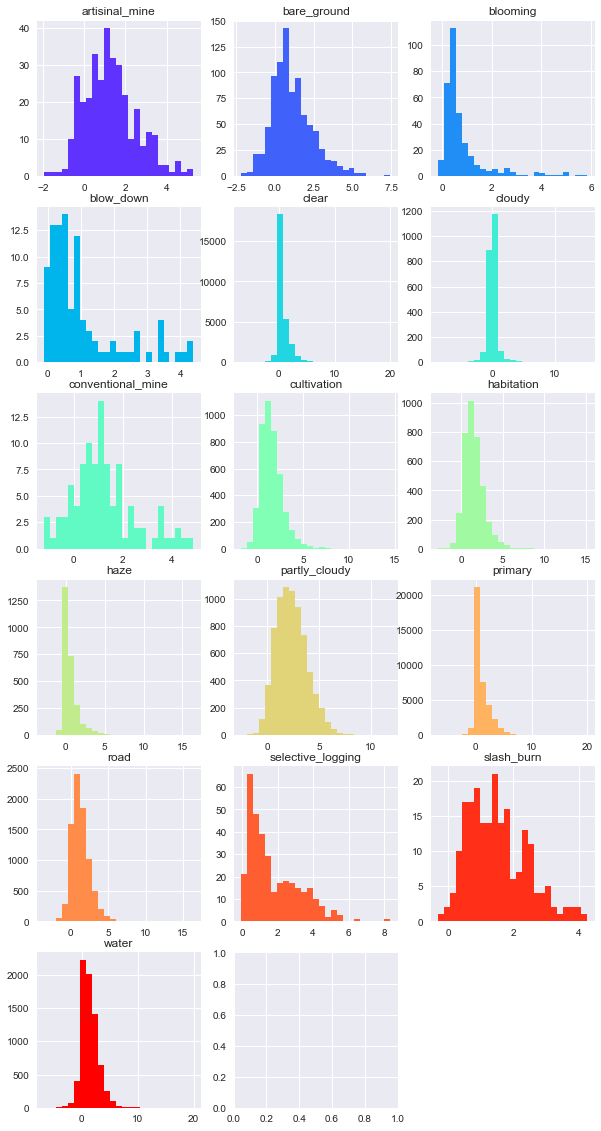

In [124]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 20)

#create table of each feature histograms for each label
X_train.set_index(y_train.index, inplace=True)
print(X_train.columns) #possible features to plot

colors = cm.rainbow(np.linspace(0, 1, len(y_train.columns))) #pick colors for plots by labels

#function to plot distributions of a featur by class label
def plot_a_feature_by_labels(feature):
    for i in np.arange(0, len(y_train.columns)):
        col=y_train.columns[i]
        ind_list = y_train[y_train[col]==1].index.tolist()
        X_train.ix[ind_list][feature].hist(bins=25, color=colors[i])
        plt.title(col)
        plt.grid(True)
        plt.subplot(6,3,i+1) 
        
#plot_a_feature_by_labels('b_bimodal')        
plot_a_feature_by_labels('b_skew')